# 🔎 Exploratory Data Analysis of TFM - Network Demand and Statistics

Key Information:
 - Transport for London (Open Data): https://tfl.gov.uk/info-for/open-data-users/our-open-data?intcmp=3671#on-this-page-2
 - Network Demand Data: https://tfl.gov.uk/corporate/publications-and-reports/network-demand-data

The goal of this notebook is to get an overview of the Network demand data of the Tube and Bus London Transport.

### Notebook Set Up

In [5]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [7]:
# Visualizations Settings
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (12, 4)
sns.despine(offset=5, trim=True)


<Figure size 1200x400 with 0 Axes>

### Quick Data Overview

In [9]:
DATA_DIR = Path("/Users/nicoletondu/Desktop/data-science-thesis-2025/data")
FILES = [
    DATA_DIR / "Journeys_2023.csv",
    DATA_DIR / "Journeys_2024_2025.csv",  # mind the space in filename
]

In [11]:
# expected columns
cols = ["TravelDate", "DayOfWeek", "TubeJourneyCount", "BusJourneyCount"]

def read_simple(path):
    df = pd.read_csv(path, usecols=cols)
    df["date"] = pd.to_datetime(df["TravelDate"].astype(str), format="%Y%m%d", errors="coerce")
    df["day_name"] = df["DayOfWeek"].astype("category")
    df["TubeJourneyCount"] = pd.to_numeric(df["TubeJourneyCount"], errors="coerce")
    df["BusJourneyCount"] = pd.to_numeric(df["BusJourneyCount"], errors="coerce")
    return df.dropna(subset=["date"])[["date", "day_name", "TubeJourneyCount", "BusJourneyCount"]]

In [13]:
journeys_df = pd.concat([read_simple(p) for p in FILES], ignore_index=True).sort_values("date")

In [15]:
# Check shape to confirm rows added
journeys_df.shape

(938, 4)

In [17]:
journeys_df.head()

,date,day_name,TubeJourneyCount,BusJourneyCount
0,2023-01-01,Sunday,1494000,2149000
1,2023-01-02,Monday,1918000,2959000
2,2023-01-03,Tuesday,2255000,4227000
3,2023-01-04,Wednesday,2387000,4713000
4,2023-01-05,Thursday,2519000,4830000


In [19]:
journeys_df.dtypes

date                datetime64[ns]
day_name                  category
TubeJourneyCount             int64
BusJourneyCount              int64
dtype: object

In [23]:
# Feature engineering
eda = journeys_df.copy()
eda["year"] = eda["date"].dt.year
eda["month"] = eda["date"].dt.month
eda["week"] = eda["date"].dt.isocalendar().week.astype(int)
eda["dow"] = eda["date"].dt.dayofweek  # Monday=0
eda["is_weekend"] = eda["dow"].isin([5, 6])
eda["total_journeys"] = eda["TubeJourneyCount"] + eda["BusJourneyCount"]
eda.head()

,date,day_name,TubeJourneyCount,BusJourneyCount,year,month,week,dow,is_weekend,total_journeys
0,2023-01-01,Sunday,1494000,2149000,2023,1,52,6,True,3643000
1,2023-01-02,Monday,1918000,2959000,2023,1,1,0,False,4877000
2,2023-01-03,Tuesday,2255000,4227000,2023,1,1,1,False,6482000
3,2023-01-04,Wednesday,2387000,4713000,2023,1,1,2,False,7100000
4,2023-01-05,Thursday,2519000,4830000,2023,1,1,3,False,7349000


In [32]:
round(eda.describe(),1)

,date,TubeJourneyCount,BusJourneyCount,year,month,week,dow,total_journeys
count,938,938.0,938.0,938.0,938.0,938.0,938.0,938.0
mean,2024-04-13 12:00:00,3165471.2,4640327.3,2023.8,6.0,24.1,3.0,7805798.5
min,2023-01-01 00:00:00,0.0,1000.0,2023.0,1.0,1.0,0.0,1000.0
25%,2023-08-23 06:00:00,2922000.0,4320500.0,2023.0,3.0,12.0,1.0,7314250.0
50%,2024-04-13 12:00:00,3299500.0,4929500.0,2024.0,6.0,23.0,3.0,8224000.0
75%,2024-12-03 18:00:00,3616750.0,5221750.0,2024.0,9.0,36.0,5.0,8838750.0
max,2025-07-26 00:00:00,4350000.0,5695000.0,2025.0,12.0,52.0,6.0,9722000.0
std,NaN,608335.3,783902.7,0.8,3.4,14.6,2.0,1351369.7


### Time Series Analysis

In [58]:
# --- aggregates (outside functions) ---
df = eda.sort_values('date').set_index('date')  # use your df name here

daily   = df[['TubeJourneyCount', 'BusJourneyCount']]
weekly  = df.resample('W-SUN')[['TubeJourneyCount', 'BusJourneyCount']].sum()
monthly = df.resample('MS')[['TubeJourneyCount', 'BusJourneyCount']].sum()
yearly  = df.resample('Y')[['TubeJourneyCount', 'BusJourneyCount']].sum()

/var/folders/f1/2npg6yrs3b9gbyk7t410_xsc0000gn/T/ipykernel_94578/3623963263.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly  = df.resample('Y')[['TubeJourneyCount', 'BusJourneyCount']].sum()


In [60]:
# plotting functions
def plot_two_series(ts, title, monthly_ticks=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(ts.index, ts['TubeJourneyCount'], label='Tube', linewidth=2)
    ax.plot(ts.index, ts['BusJourneyCount'], label='Bus', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel('date'); ax.set_ylabel('journeys')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    if monthly_ticks:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

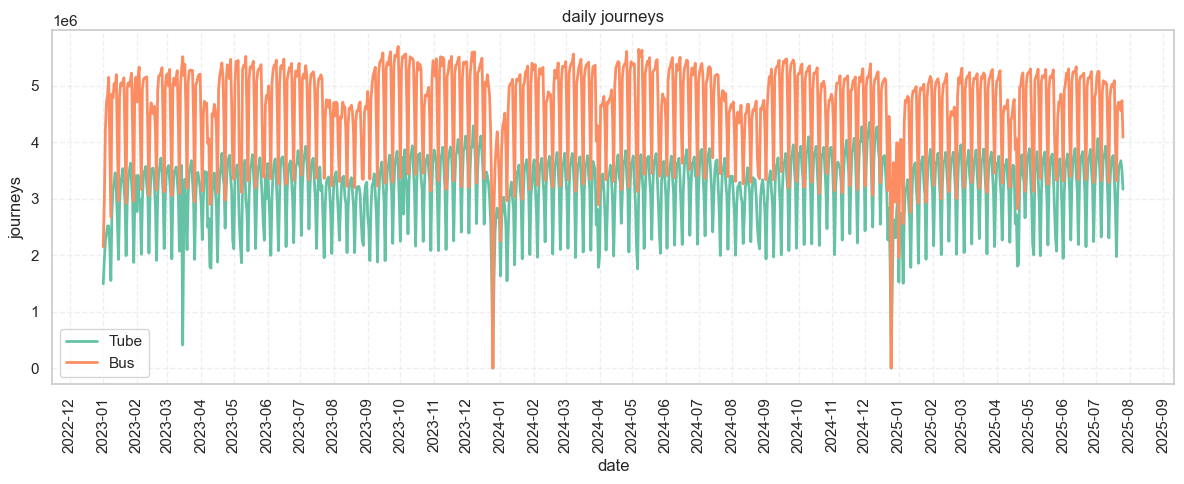

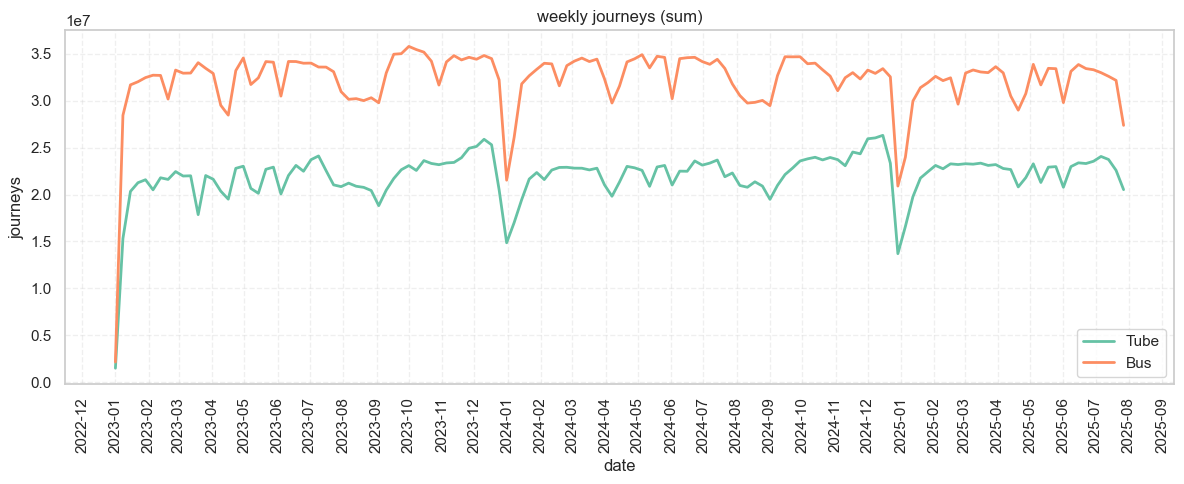

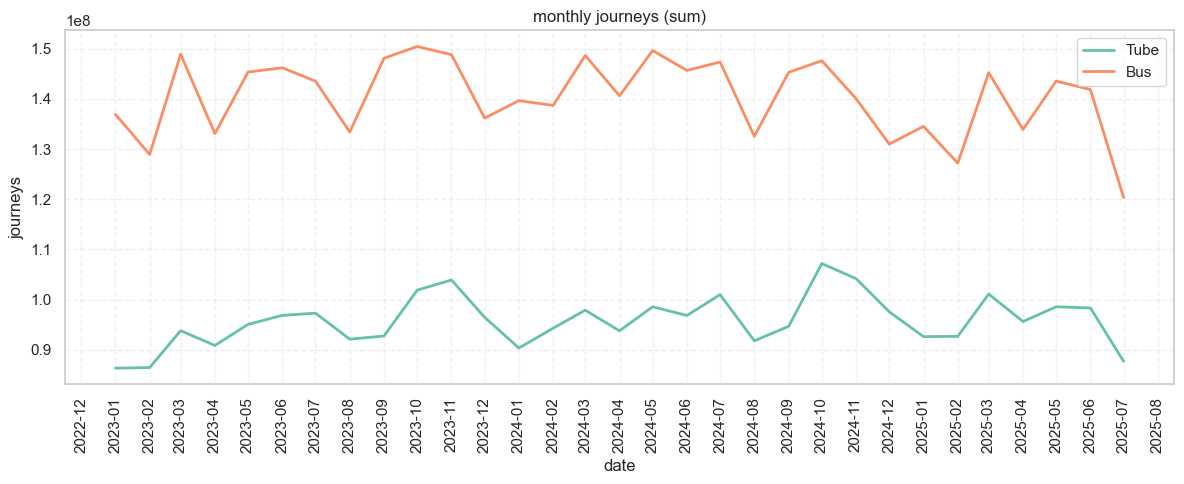

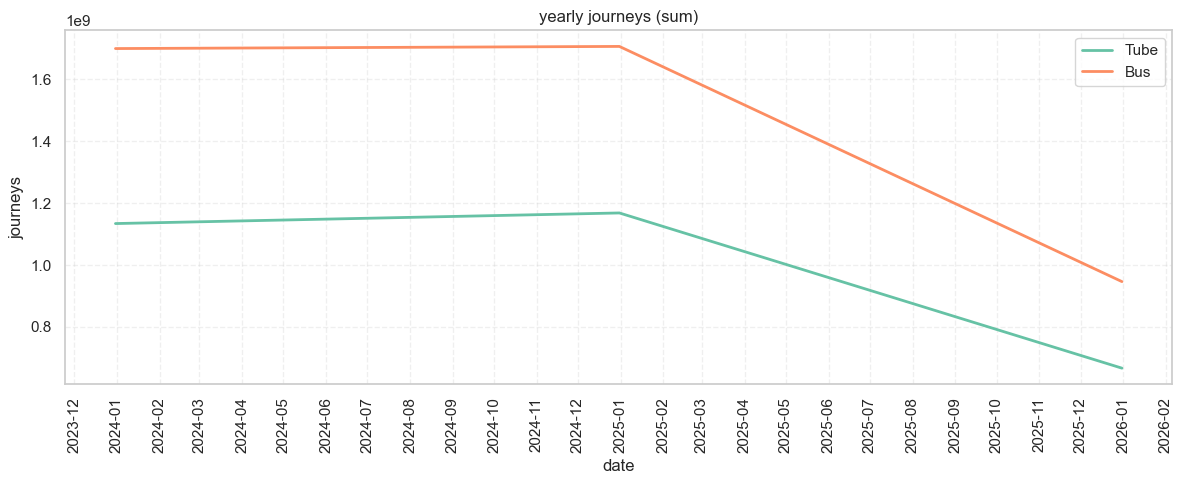

In [54]:
# --- plots ---
plot_two_series(daily,   'daily journeys', monthly_ticks=True)
plot_two_series(weekly,  'weekly journeys (sum)', monthly_ticks=True)
plot_two_series(monthly, 'monthly journeys (sum)', monthly_ticks=True)  # clear monthly ticks
plot_two_series(yearly,  'yearly journeys (sum)', monthly_ticks=True)

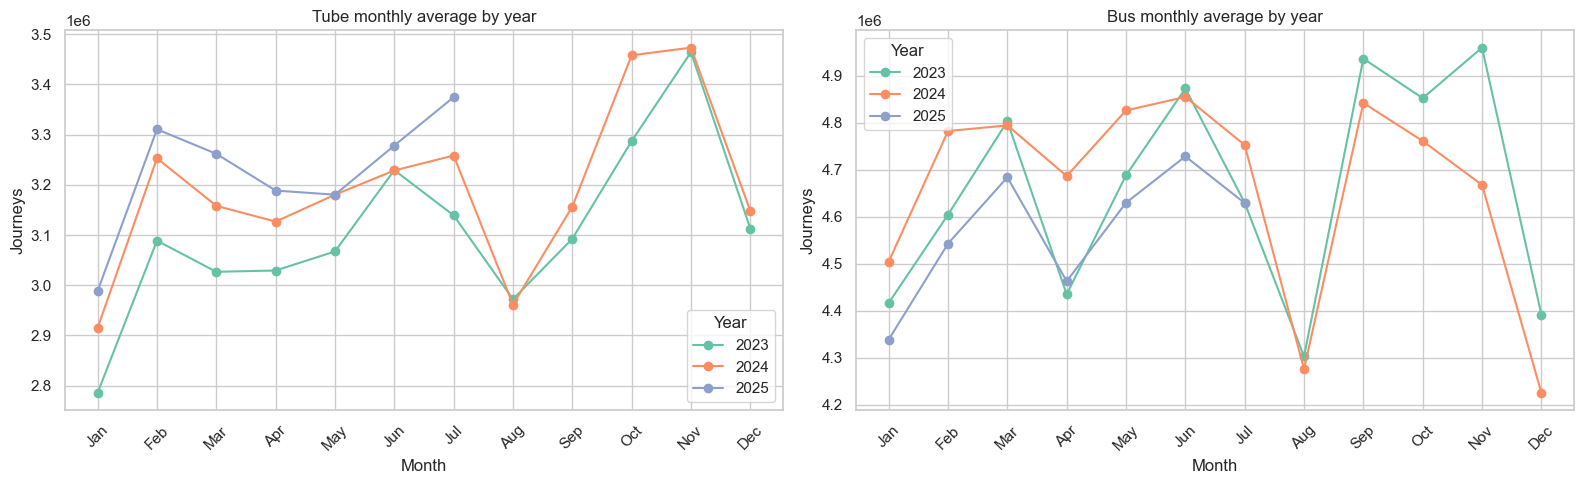

In [89]:
# Year-over-year comparison (monthly averages)
monthly_avg = eda.groupby(["year", "month"], as_index=False)[["TubeJourneyCount", "BusJourneyCount"]].mean()
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Month labels for x-axis
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for ax, col, title in [
    (axes[0], "TubeJourneyCount", "Tube monthly average by year"),
    (axes[1], "BusJourneyCount", "Bus monthly average by year"),
]:
    for y, grp in monthly_avg.groupby("year"):
        ax.plot(grp["month"], grp[col], marker="o", label=str(y))
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Journeys")
    ax.legend(title="Year")
    # Set monthly ticks and labels
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=45)

plt.tight_layout()

### Journey By Weekday

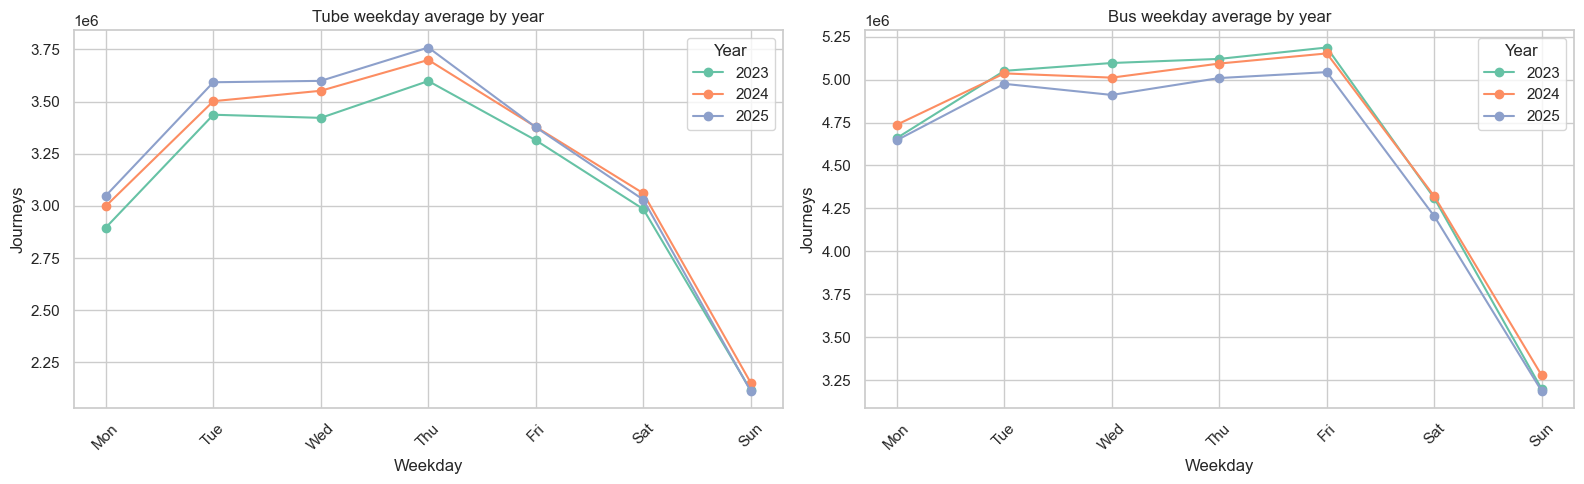

In [91]:
# Year-over-year comparison (weekday averages)
weekday_avg = eda.groupby(["year", "dow"], as_index=False)[["TubeJourneyCount", "BusJourneyCount"]].mean()
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

# Weekday labels for x-axis (Monday=0, Sunday=6)
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for ax, col, title in [
    (axes[0], "TubeJourneyCount", "Tube weekday average by year"),
    (axes[1], "BusJourneyCount", "Bus weekday average by year"),
]:
    for y, grp in weekday_avg.groupby("year"):
        ax.plot(grp["dow"], grp[col], marker="o", label=str(y))
    ax.set_title(title)
    ax.set_xlabel("Weekday")
    ax.set_ylabel("Journeys")
    ax.legend(title="Year")
    # Set weekday ticks and labels
    ax.set_xticks(range(7))
    ax.set_xticklabels(weekday_labels, rotation=45)

plt.tight_layout()

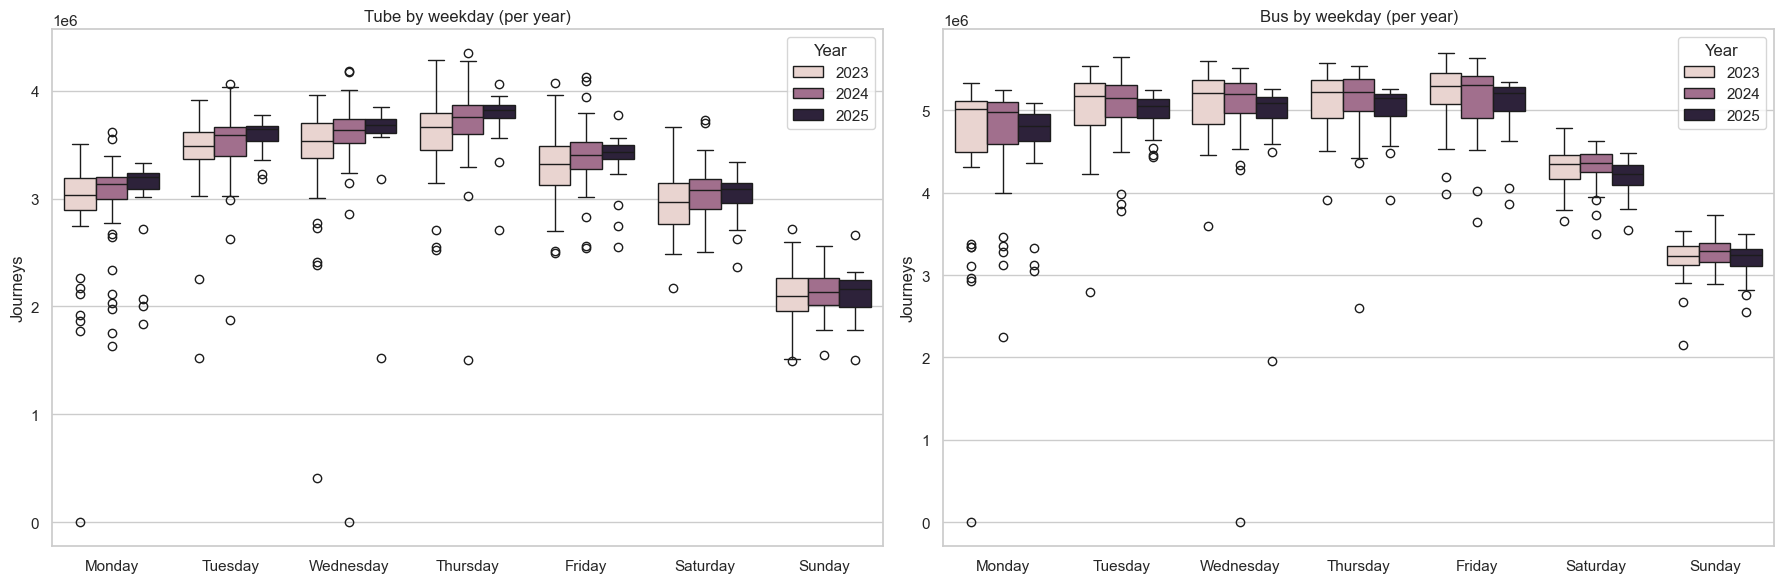

In [64]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Tube journeys by weekday + year
sns.boxplot(
    data=eda,
    x="day_name", y="TubeJourneyCount",
    hue="year",
    order=order,
    ax=axes[0]
)
axes[0].set_title("Tube by weekday (per year)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Journeys")
axes[0].legend(title="Year")

# Bus journeys by weekday + year
sns.boxplot(
    data=eda,
    x="day_name", y="BusJourneyCount",
    hue="year",
    order=order,
    ax=axes[1]
)
axes[1].set_title("Bus by weekday (per year)")
axes[1].set_xlabel("")
axes[1].set_ylabel("Journeys")
axes[1].legend(title="Year")

plt.tight_layout()
plt.show()


### Heatmap: Average daily journeys by Month x Weekday

/var/folders/f1/2npg6yrs3b9gbyk7t410_xsc0000gn/T/ipykernel_94578/2290441047.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat.groupby(["day_name", "month_name"], as_index=False)


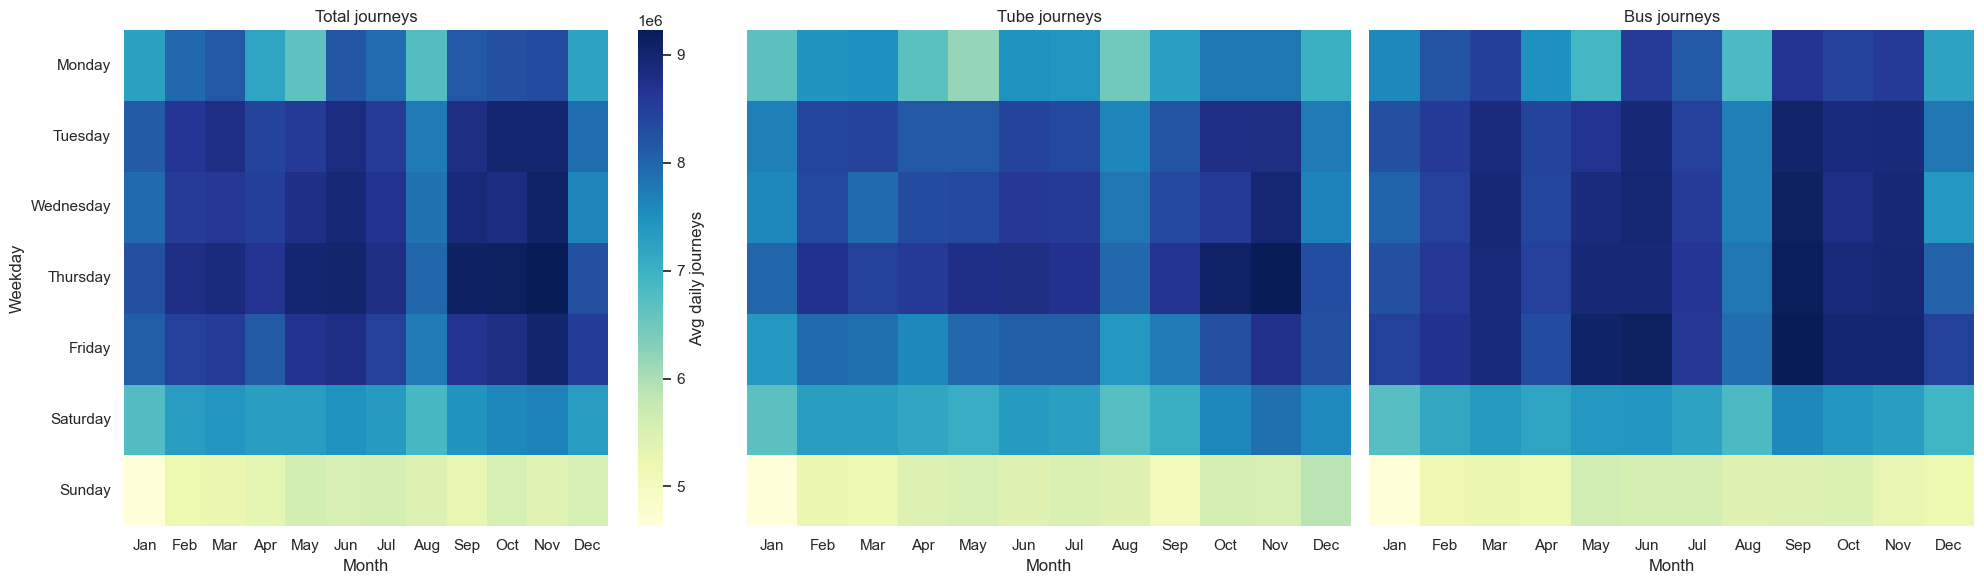

In [86]:
# Heatmap: Average daily journeys by Month x Weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_map = {i + 1: name for i, name in enumerate(month_order)}

heat = eda.assign(month_name=eda["month"].map(month_map))
agg = (
    heat.groupby(["day_name", "month_name"], as_index=False)
    [["TubeJourneyCount", "BusJourneyCount", "total_journeys"]]
    .mean()
)

p_total = (
    agg.pivot(index="day_name", columns="month_name", values="total_journeys")
    .reindex(index=weekday_order, columns=month_order)
)
p_tube = (
    agg.pivot(index="day_name", columns="month_name", values="TubeJourneyCount")
    .reindex(index=weekday_order, columns=month_order)
)
p_bus = (
    agg.pivot(index="day_name", columns="month_name", values="BusJourneyCount")
    .reindex(index=weekday_order, columns=month_order)
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
sns.heatmap(p_total, cmap="YlGnBu", ax=axes[0], cbar_kws={"label": "Avg daily journeys"})
axes[0].set_title("Total journeys")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Weekday")

sns.heatmap(p_tube, cmap="YlGnBu", ax=axes[1], cbar=False)
axes[1].set_title("Tube journeys")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("")

sns.heatmap(p_bus, cmap="YlGnBu", ax=axes[2], cbar=False)
axes[2].set_title("Bus journeys")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("")

plt.tight_layout()